Input Directory Format Example:

Breast_Cancer_Dataset

------Duke-Breast-Cancer-MRI

-------------Breast_MRI_001

---------------------01-01-1990-NA-MRI BREAST BILATERAL WWO-97538

------------------------------------3.000000-ax dyn pre-93877

------------------------------------5.000000-ax dyn 1st pass-59529

------------------------------------8.000000-ax dyn 2nd pass-92755

------------------------------------11.000000-ax dyn 3rd pass-41458

------------------------------------14.000000-ax dyn 4th pass-47500

-------------------------------------------------1-001.dcm

-------------------------------------------------1-002.dcm

Image sequences should be of similar length.
Need to train/test split by patient AND seperate by sequence(Image sequence order matters). Each patient will have 5-7 seqeunces in the form of a 3D Tensor. Each patient will have a TNM label. Each patient will have tabular features. Label and features DO NOT differ by sequence. They differ by patient. 

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt
import imutils
import os
import re

In [46]:
class Breast_MRI(Dataset):
  def __init__(self, root_dir, labels_csv, features_csv):
    self.root_dir = root_dir
    self.target_size = (512, 512)
    self.transform = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize(self.target_size),
                                         transforms.ToTensor()])
    self.corrupted_files = []
    # Load sequences
    self.sequences = self.load_images()
    print(f"Dataset initialized with {len(self.sequences)} sequences")
      
    self.labels = labels_csv
    self.features = features_csv
    
  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    # """
    #     Returns:
    #         images: [num_slices, C, H, W] tensor
    #         features: [10] tensor
    #         label: [TNM] int
    # """
      
    sequence_images = []
    sequence_path = self.sequences[index]['image_paths']
    label = 0
    # label = self.labels[index]
    for image_path in sequence_path:
        image = pydicom.dcmread(image_path).pixel_array
        print(f'Image Shape Before Preprocessing: {image.shape}')  # (448, 448)
        image = self.crop_image(image, image_path)
        image = self.transform(image)
        sequence_images.append(image)
        print(f'Image Shape After Preprocessing: {image.shape}')  # torch.Size([1, 512, 512])
        
    sequence = torch.stack(sequence_images)  # Shape: [num_slices, C, H, W] 
    return sequence, label

  # Load all image paths into its corresponding sequence. Keeps track of patient id and sequence name. Loads sequence into self.sequences
  # Will load and preprocess as sequences of images(3D Tensor)
  def load_images(self):
    # Root Directory: "D:\Breast_Cancer_Dataset\Duke-Breast-Cancer-MRI"

      # """
      #   Load directory structure and organize as SEQUENCES
        
      #   Returns:
      #       List of dicts: [
      #           {'patient_id': 'xx', 'sequence_name': 'yy', 'image_paths': [...]},
      #           ...
      #       ]
      #   """
      
    patients = []
    sequences = []
      
    # 5-7 Seqeunces per patient
    # Need to seperate by sequence AND patient
    for directory in os.listdir(self.root_dir):
        patient_path = os.path.join(self.root_dir, directory)
        patients.append(patient_path)
        
    print(len(patients))
    # Inside each patient folder is a date folder. In that folder is 5-7 sequence folders.
    sequence_folders = []
    for patient in patients:
        # Date Level Folders
        for date_folder in os.listdir(patient): 
            
            if len(os.listdir(patient)) > 1:
                raise Exception('Found More Than 1 Data Folder')
            if len(os.listdir(patient)) == 0:
                raise Exception('NO Date Folder Found')
                  
            date_path = os.path.join(patient, date_folder)
            # Corrupted Folders
            try:
                os.listdir(date_path)
            except (PermissionError, OSError) as e:
                print(f"⚠️ Skipping {patient} due to error: {e}")
                self.corrupted_files.append(date_path)
                continue
            
            # Sequence Level Folders 
            for sequence_folder in os.listdir(date_path):
                sequence_path = os.path.join(date_path, sequence_folder)
                sequence_folders.append(sequence_path)

    # Each sequence folder contains about 50-150 DICOM images.
    for sequence_folder in sequence_folders:
        match = re.search(r'(Breast_MRI_\d+)', sequence_folder)
        patient_id = match.group(1)
        # Image paths for this sequence
        image_paths = []
        sequence_name = os.path.basename(sequence_folder)
        # Step into folder to access DICOM images
         # Corrupted Files
        try:
            os.listdir(sequence_folder)
        except (PermissionError, OSError) as e:
            print(f"⚠️ Skipping {sequence_folder} due to error: {e}")
            self.corrupted_files.append(sequence_folder)
            continue
        for file in os.listdir(sequence_folder):
            image_path = os.path.join(sequence_folder, file)
            image_paths.append(image_path)

        # Add this sequence to our list
        sequences.append({
            'patient_id': patient_id,
            'sequence_name': sequence_name,
            'image_paths': image_paths,
            'num_images': len(image_paths)
        })
        break
        

    print(f'Sequences Length: {len(sequences)}')
    return sequences

  def crop_image(self, image, path):
        # Convert to range [0-255] and datatype np.uint8
        new_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
      
        # Reduce noise and smooth image.
        new_image = cv2.GaussianBlur(new_image,(5, 5), 0)

        # Converts image to binary (black and white) pixels above 45 are white(255). Pixels below 45 become black(0).
        # Isolates bright regions in MRI(brain tissue).
        new_image = cv2.threshold(new_image, 28, 255, cv2.THRESH_BINARY)[1]

        # Morphological Operations to smooth and clean binary mask:
        # Helps see contours easily, removes small white noise.
        new_image = cv2.erode(new_image, None, iterations=2)
        # Expands white areas back to original size.
        new_image = cv2.dilate(new_image, None, iterations=2)
        # Send as copy so data is not lost, retrieves only outermost contours(RETR_EXTERNAL).
        contours = cv2.findContours(new_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = imutils.grab_contours(contours)

        # Safety Check
        if not contours:
            print("[WARNING] No contours found!")
            print(path)
            return image

        # Get the largest contour by measuring the area. The largest contour will be the outer tissue.
        contours = max(contours, key=cv2.contourArea)
        # Bounding boxes of contour/tissue. Need left, right, top, and bottom.
        ext_left = tuple(contours[contours[:, : , 0].argmin()])[0]
        ext_right = tuple(contours[contours[:, :, 0].argmax()])[0]
        ext_top = tuple(contours[contours[:, :, 1].argmin()])[0]
        ext_bottom = tuple(contours[contours[:, :, 1].argmax()])[0]
    
        # Slice the image through rectangular bounding box.
        cropped_image = image[ext_top[1]: ext_bottom[1], ext_left[0]: ext_right[0]]

        # Convert cropped image to uint8 for transforms
        if cropped_image.dtype == np.uint16:
            cropped_image = cv2.normalize(cropped_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        return cropped_image

In [47]:
root_directory = r"D:\Breast_Cancer_Dataset\Duke-Breast-Cancer-MRI"
mri = Breast_MRI(root_directory, labels_csv=None, features_csv=None)
print(mri.corrupted_files)

922
⚠️ Skipping D:\Breast_Cancer_Dataset\Duke-Breast-Cancer-MRI\Breast_MRI_030 due to error: [WinError 23] Data error (cyclic redundancy check): 'D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_030\\01-01-1990-NA-MRI BREAST BILATERAL WWO-47611'
⚠️ Skipping D:\Breast_Cancer_Dataset\Duke-Breast-Cancer-MRI\Breast_MRI_042 due to error: [WinError 23] Data error (cyclic redundancy check): 'D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_042\\01-01-1990-NA-BREASTlesion evaluation-16139'
Sequences Length: 1
Dataset initialized with 1 sequences
['D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_030\\01-01-1990-NA-MRI BREAST BILATERAL WWO-47611', 'D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_042\\01-01-1990-NA-BREASTlesion evaluation-16139']


In [48]:
print(len(mri.corrupted_files))
print(len(mri.sequences))
mri.sequences

2
1


[{'patient_id': 'Breast_MRI_001',
  'sequence_name': '11.000000-ax dyn 3rd pass-41458',
  'image_paths': ['D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_001\\01-01-1990-NA-MRI BREAST BILATERAL WWO-97538\\11.000000-ax dyn 3rd pass-41458\\1-001.dcm',
   'D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_001\\01-01-1990-NA-MRI BREAST BILATERAL WWO-97538\\11.000000-ax dyn 3rd pass-41458\\1-002.dcm',
   'D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_001\\01-01-1990-NA-MRI BREAST BILATERAL WWO-97538\\11.000000-ax dyn 3rd pass-41458\\1-003.dcm',
   'D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_001\\01-01-1990-NA-MRI BREAST BILATERAL WWO-97538\\11.000000-ax dyn 3rd pass-41458\\1-004.dcm',
   'D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_001\\01-01-1990-NA-MRI BREAST BILATERAL WWO-97538\\11.000000-ax dyn 3rd pass-41458\\1-005.dcm',
   'D:\\Breast_Cancer_Dataset\\Duke-Breast-Cancer-MRI\\Breast_MRI_001\\01-01-1990-NA-MR

Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After Preprocessing: torch.Size([1, 512, 512])
Image Shape Before Preprocessing: (448, 448)
Image Shape After P

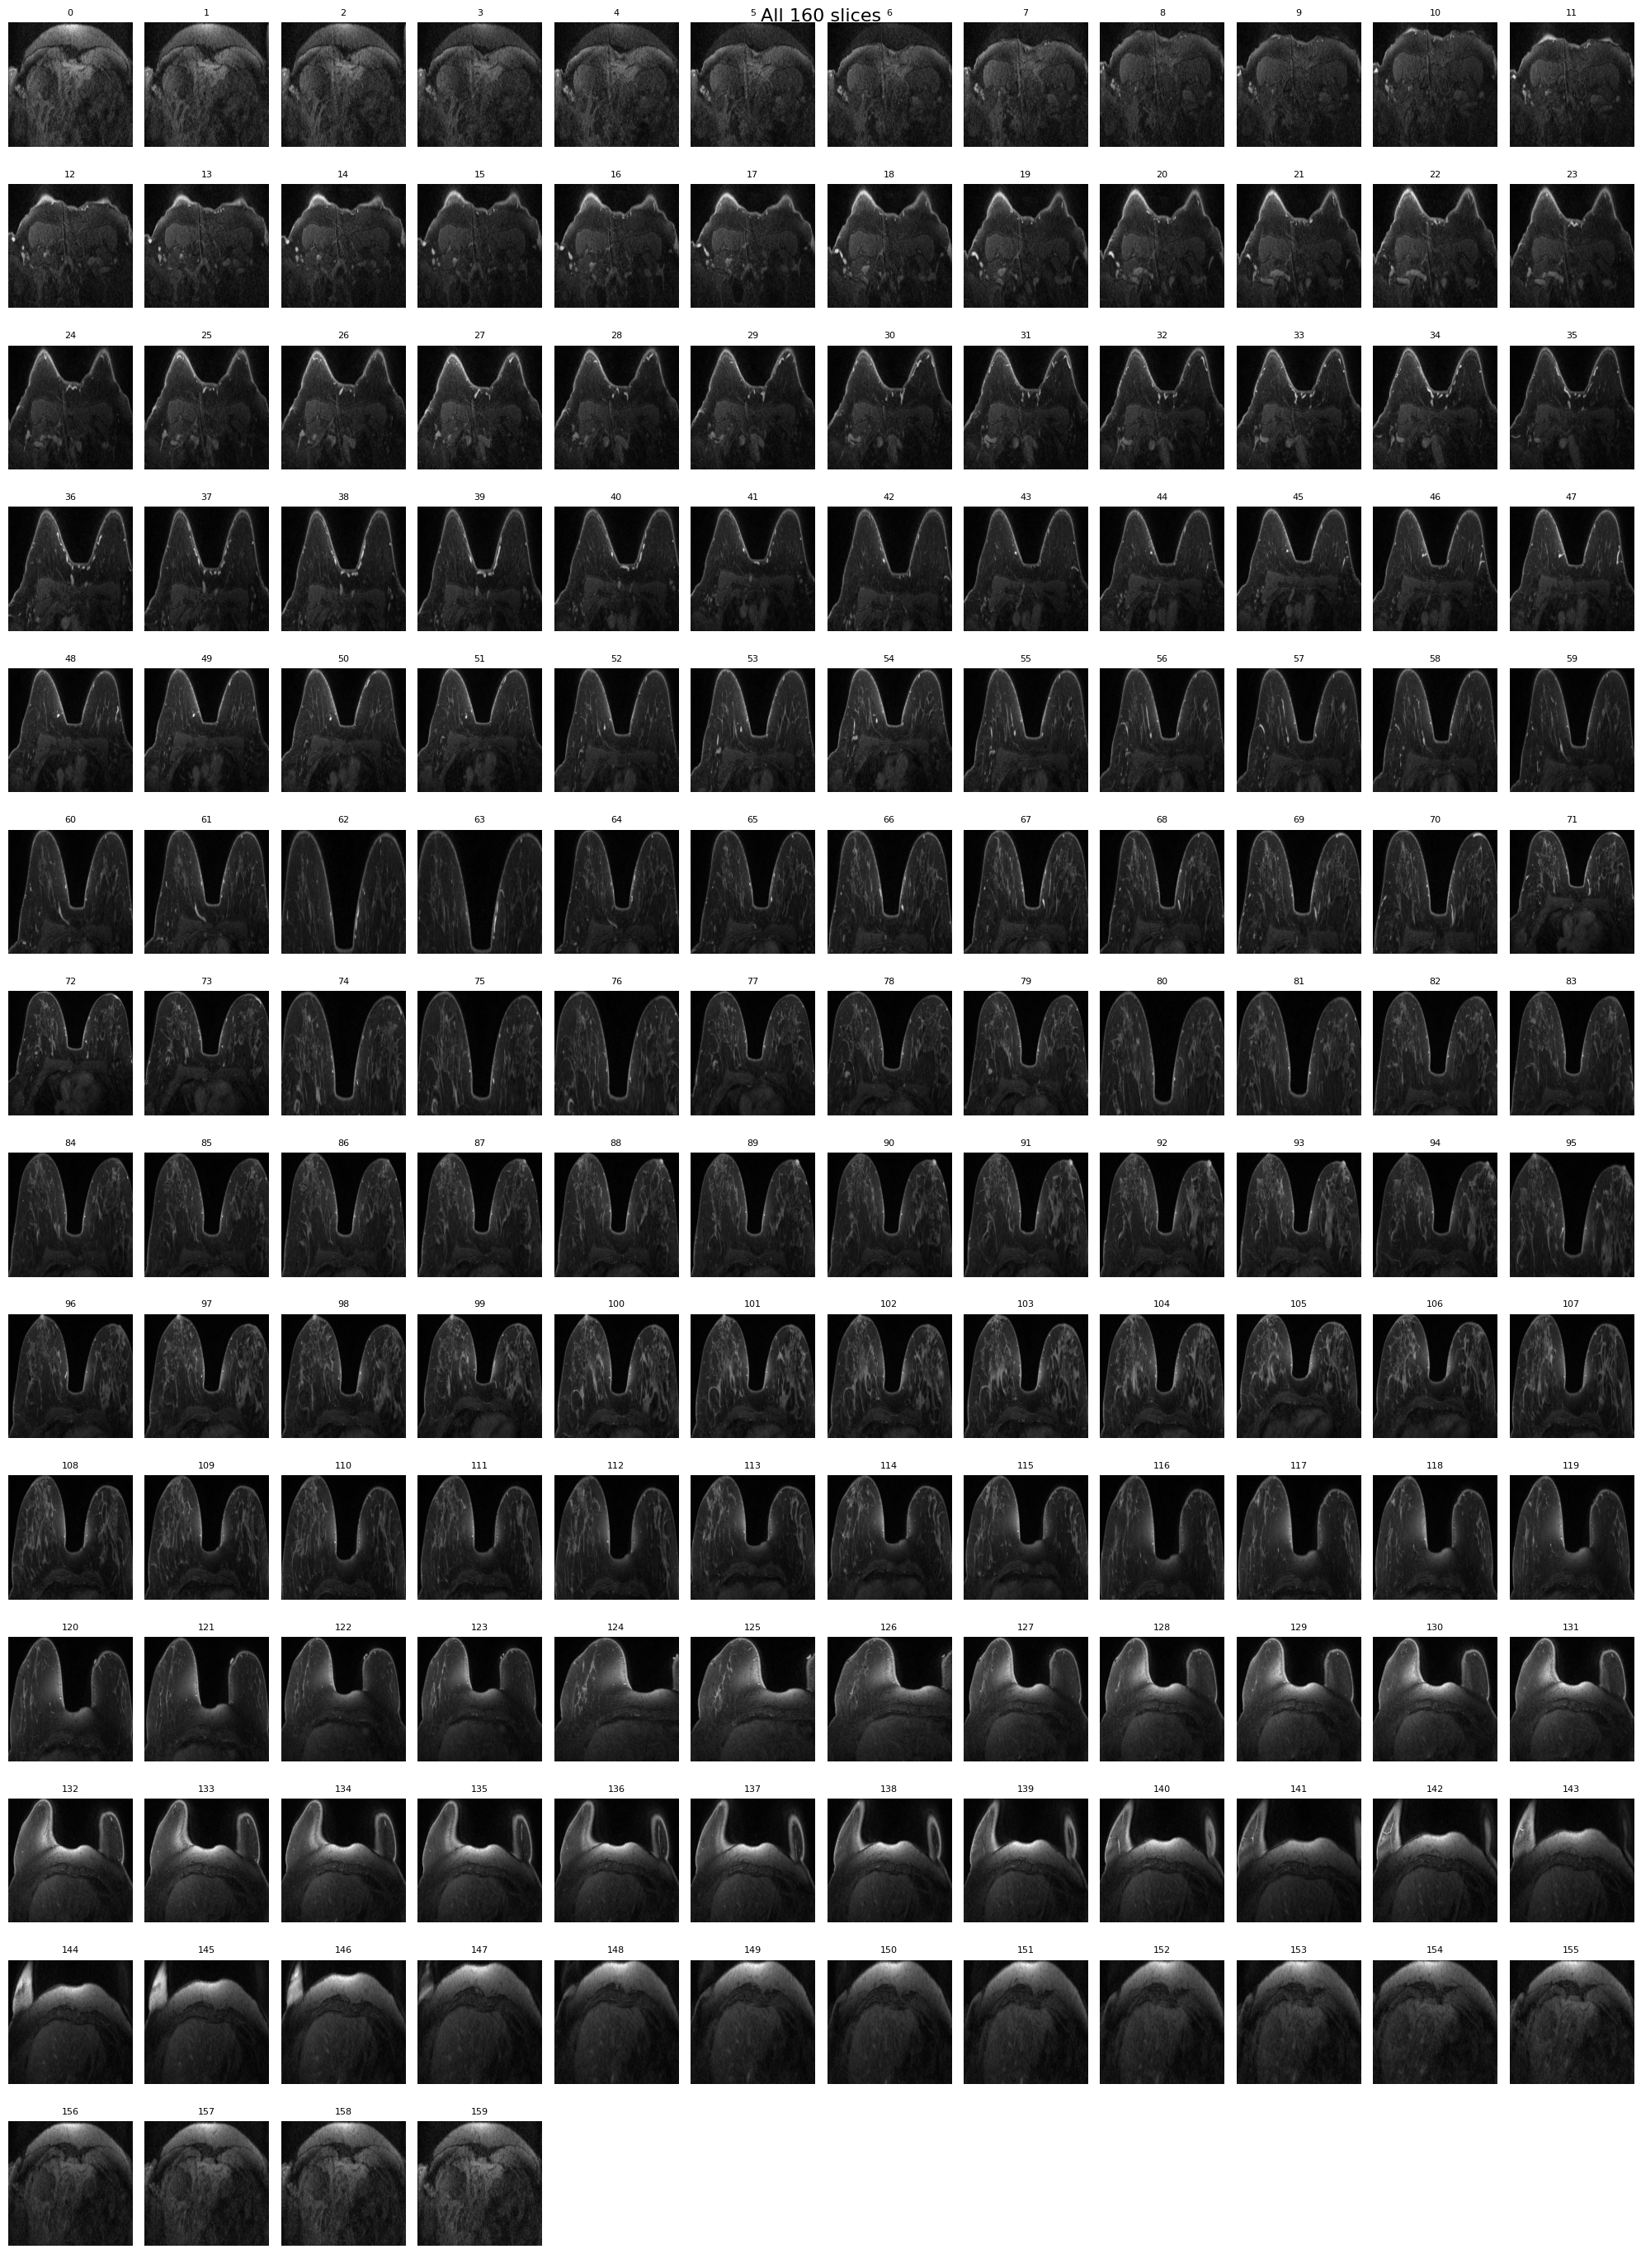

In [49]:
# "D:\Breast_Cancer_Dataset\Duke-Breast-Cancer-MRI\Breast_MRI_001\01-01-1990-NA-MRI BREAST BILATERAL WWO-97538\3.000000-ax dyn pre-93877"
sequence = mri.__getitem__(0)[0]  # Get sequence
sequence = sequence.squeeze()  # Remove channel dimension(Grayscale)

n_slices = len(sequence)
n_cols = 12  
n_rows = int(np.ceil(n_slices / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < n_slices:
        axes[i].imshow(sequence[i], cmap='gray')
        axes[i].set_title(f'{i}', fontsize=8)
    axes[i].axis('off')
    
plt.suptitle(f'All {n_slices} slices', fontsize=16)
plt.tight_layout()
plt.show()